# Step 0: Invoking Libraries/Packages

In [2]:
# Packages/Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import sklearn
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

import warnings
warnings.filterwarnings('ignore')

# Step 1: Reading, Understanding and Cleaning the Data

### __Used day.csv file as main data source__

In [5]:
# load the day.csv file and named the dataframe as bike_df
bike_df = pd.read_csv('day.csv') # Used initally: bike_df = pd.read_csv("day.csv", low_memory = False)

pd.set_option("display.max_columns",300)   # Increase visibility by full Columns
pd.set_option("display.max_rows",115)      # Increase visibility by full Rows
bike_df.shape

(730, 16)

### Data Quality Check

In [7]:
# Display a concise summary of the DataFrame, including the data types, for each column in 'bike_df'.
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [8]:
# Checking for null values
print(bike_df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [9]:
# Verifying Missing Values Column Wise
round(100*(bike_df.isnull().sum()/len(bike_df)), 2).sort_values(ascending=False)

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

In [10]:
# Verifying Missing Values Row Wise
round((bike_df.isnull().sum(axis=1)/len(bike_df))*100,2).sort_values(ascending=False)

0      0.0
479    0.0
481    0.0
482    0.0
483    0.0
      ... 
245    0.0
246    0.0
247    0.0
248    0.0
729    0.0
Length: 730, dtype: float64

In [11]:
# Duplicate Check
# Checking for duplicates and dropping the entire duplicate row if any
print(bike_df.duplicated().sum())

0


In [12]:
# Check for inconsistencies in the 'cnt' column of the DataFrame.
# 'cnt' is expected to equal the sum of 'casual' and 'registered'.
# Count the number of rows where this condition is not met,
inconsistent_cnt = (bike_df['cnt'] != bike_df['casual'] + bike_df['registered']).sum()
# print the result.
print(f"Inconsistent 'cnt' values: {inconsistent_cnt}")


Inconsistent 'cnt' values: 0


**Observation**
- There is no null values present in dataset.
- There is no any duplicated are present in dataset.
- This the shape of the initial dataset - (730, 16).

In [14]:
# Moveing 'cnt' to the first position in df_train as it is target var
bike_df = bike_df[['cnt'] + [col for col in bike_df.columns if col != 'cnt']]

### Data Cleaning

- Identify any Unknow/Junk values present in the dataframe

            cnt      temp     atemp
cnt    1.000000  0.627044  0.630685
temp   0.627044  1.000000  0.991696
atemp  0.630685  0.991696  1.000000


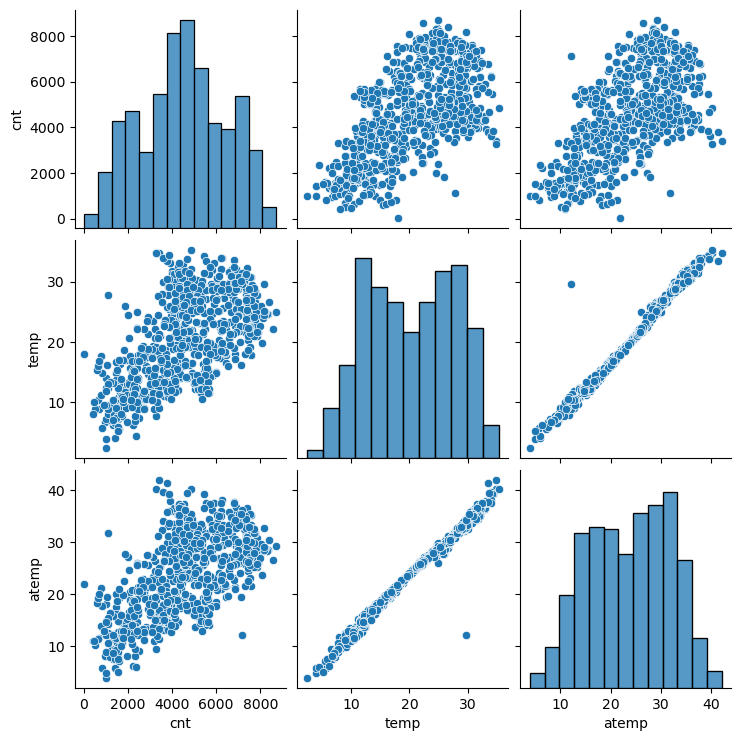

In [17]:
sns.pairplot(data=bike_df,vars=['cnt','temp','atemp'])
corr_matrix = bike_df[['cnt','temp','atemp']].corr()
print(corr_matrix)

- **Observations for column removal:**
- The 'instant' column is not useful as it is simply an index and does not add any meaningful information to the analysis.
- The 'casual' and 'registered' columns are redundant since 'cnt' already represents their combined value, making them unnecessary.
- The 'atemp' column is almost redundant as its correlation with 'cnt' (0.630685) is nearly identical to that of 'temp' (0.627044), and both have a very similar distribution in scatter plots. Retaining only 'temp' suffices for analysis.
- Removing these columns simplifies the dataset while retaining all necessary information for meaningful insights.

In [19]:
# Removing redundant & unwanted columns
bike_df.drop(columns=['instant', 'atemp', 'casual', 'registered'], inplace=True)

In [20]:
# Derive the weekday from the 'dteday' column
bike_df['derived_weekday'] = pd.to_datetime(bike_df['dteday'],format='mixed', dayfirst=True).dt.dayofweek  # 0 = Monday, 6 = Sunday

# Compare the derived weekday with the existing 'weekday' column
comparison = bike_df[['weekday', 'derived_weekday']]

# Check for mismatches
mismatches = bike_df[bike_df['weekday'] != bike_df['derived_weekday']]

# Print the mismatched rows
print("Mismatches between present and derived weekday data:")
print(mismatches[['dteday', 'weekday', 'derived_weekday']])

Mismatches between present and derived weekday data:
         dteday  weekday  derived_weekday
0      1/1/2018        6                0
1      2/1/2018        0                1
2      3/1/2018        1                2
3      4/1/2018        2                3
4      5/1/2018        3                4
..          ...      ...              ...
419  24-02-2019        5                6
420  25-02-2019        6                0
421  26-02-2019        0                1
422  27-02-2019        1                2
423  28-02-2019        2                3

[424 rows x 3 columns]


**Observation-**
- Upon comparison, the derived weekday from the 'dteday' column and the existing 'weekday' column showed inconsistencies, 
indicating that the data in the 'weekday' column does not align with the actual calendar. However, modifying the 'weekday' 
and 'workingday' columns to match the derived values might deviate from the dataset's original context. 
- To maintain consistency with the dataset's intended structure, it is decided to retain the original 'weekday' and 
'workingday' columns without modification.
- The 'dteday' column, now has served its purpose, we can now remove it.

In [22]:
# Drop the 'dteday' column as it is no longer required
bike_df = bike_df.drop(columns=['dteday'])
# also the 'derived_weekday' column as it is no longer required
bike_df = bike_df.drop(columns=['derived_weekday'])

- Created a 'updt_holiday' column that combines the original 'holiday' column and weekend days (Sunday and Saturday).
- Update the 'workingday' column:
    - Set to 0 for holidays (weekends or rows marked as holiday).
    - Set to 1 for weekdays (Monday-Friday) if not a holiday.

In [24]:

# Step 1: Create the 'new_holiday' column
bike_df['updt_holiday'] = bike_df.apply(
    lambda row: 1 if row['holiday'] == 1 or row['weekday'] in [0, 6] else 0, axis=1
)

# Step 2: Update the 'workingday' column based on 'new_holiday' and 'weekday'
bike_df['workingday'] = bike_df.apply(
    lambda row: 0 if row['updt_holiday'] == 1 else (1 if row['weekday'] in [1, 2, 3, 4, 5] else 0),
    axis=1
)

# Step 3: Drop the old 'holiday' column as it's no longer needed
bike_df = bike_df.drop(columns=['holiday'])

In [25]:
# Check unique combinations of 'weekday', 'new_holiday', and 'workingday'
weekday_analysis = bike_df.groupby(['weekday', 'updt_holiday', 'workingday']).size()
print(weekday_analysis)

# Check correlation if 'weekday' is encoded as numerical
weekday_corr = bike_df[['weekday', 'updt_holiday', 'workingday']].corr()
print(weekday_corr)

# If 'weekday' is categorical, use Cramér's V to test association
from scipy.stats import chi2_contingency


# Compute a contingency table
contingency_table = pd.crosstab(bike_df['weekday'], [bike_df['updt_holiday'], bike_df['workingday']])

# Calculate Cramér's V
chi2 = chi2_contingency(contingency_table)[0]
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
print(f"Cramér's V for 'weekday', 'new_holiday', 'workingday': {cramers_v}")

weekday  updt_holiday  workingday
0        1             0             105
1        0             1              90
         1             0              15
2        0             1             103
         1             0               1
3        0             1             102
         1             0               1
4        0             1             102
         1             0               2
5        0             1             102
         1             0               2
6        1             0             105
dtype: int64
              weekday  updt_holiday  workingday
weekday        1.0000       -0.0358      0.0358
updt_holiday  -0.0358        1.0000     -1.0000
workingday     0.0358       -1.0000      1.0000
Cramér's V for 'weekday', 'new_holiday', 'workingday': 0.9387156205132579


- observation for weekday
    1. Unique Combinations Analysis: Since all patterns for weekday are fully explainable by the updt_holiday and workingday columns, weekday does not add new information.
    2. Correlation Matrix: The low correlation indicates weekday is not independently contributing meaningful information.
    3. Cramér's V = 0.94: A very strong association between weekday, updt_holiday, and workingday. This confirms that the relationship between weekday and the other two variables is highly redundant.
  - after this we can safly remove the weekday column.

In [27]:
# Drop the 'weekday' column as it is redundant
bike_df = bike_df.drop(columns=['weekday'])

- above taken steps ensures the dataset remains consistent while removing unnecessary columns that have already been utilized for analysis.

- Encoding/mapping column with constant values to informative one

In [30]:
# Map the 'mnth' column to more descriptive values
month_mapping = {
    1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr',
    5: 'may', 6: 'jun', 7: 'jul', 8: 'aug',
    9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec'
}
bike_df['mnth'] = bike_df['mnth'].map(month_mapping)

In [31]:
# Map the 'Season' column to informative values
season_mapping = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
bike_df['season'] = bike_df['season'].map(season_mapping)

In [32]:
# Map the 'weathersit' column to descriptive labels with shorter names
weathersit_mapping = {
    1: 'Clear',
    2: 'Mist',
    3: 'Light_Snow_Rain'
}

# Apply the mapping to the 'weathersit' column
bike_df['weathersit'] = bike_df['weathersit'].map(weathersit_mapping)


In [33]:
# Display the first five rows of the updated DataFrame to verify the changes, 
# including removed columns, and mapped 'Season' and 'mnth' values.
bike_df.head()

,cnt,season,yr,mnth,workingday,weathersit,temp,hum,windspeed,updt_holiday
0,985,spring,0,jan,0,Mist,14.110847,80.5833,10.749882,1
1,801,spring,0,jan,0,Mist,14.902598,69.6087,16.652113,1
2,1349,spring,0,jan,1,Clear,8.050924,43.7273,16.636703,0
3,1562,spring,0,jan,1,Clear,8.200000,59.0435,10.739832,0
4,1600,spring,0,jan,1,Clear,9.305237,43.6957,12.522300,0


# Step 2: Visualising the Data

## Exploratory Data Analysis

### Data Visualisation of various variable against target variable

#### - Univariate Analysis

count     730.000000
mean     4508.006849
std      1936.011647
min        22.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: cnt, dtype: float64


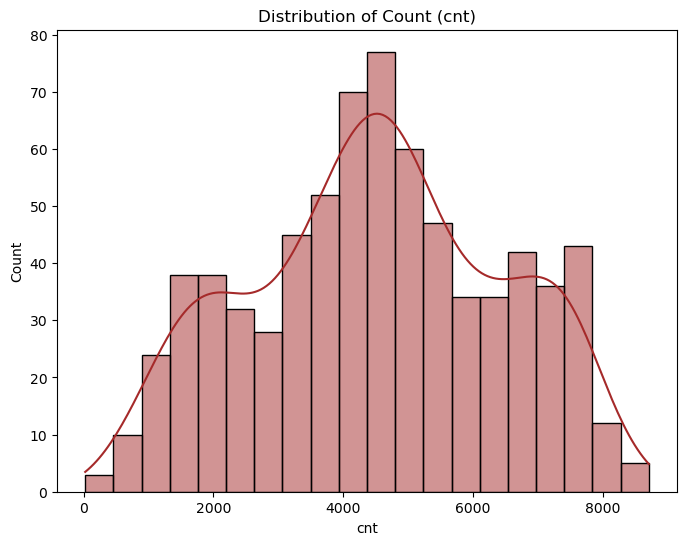

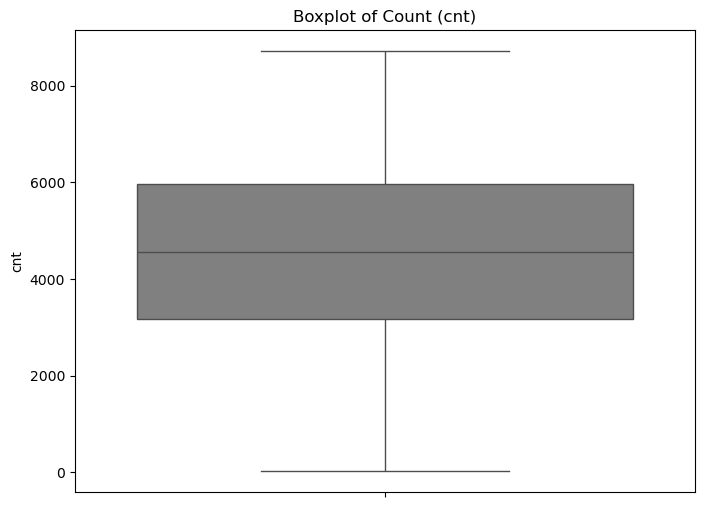

In [38]:
# Univariate Analysis for cnt column which target var
# Summary statistics for 'cnt'
cnt_stats = bike_df['cnt'].describe()
print(cnt_stats)

# Histogram of 'cnt'
plt.figure(figsize=(8,6))
sns.histplot(bike_df['cnt'], kde=True, color='brown', bins=20)
plt.title('Distribution of Count (cnt)')
plt.show()

# Boxplot for 'cnt'
plt.figure(figsize=(8,6))
sns.boxplot(data=bike_df, y='cnt', color='grey')
plt.title('Boxplot of Count (cnt)')
plt.show()

**Observation**
- The histogram shows a roughly bell-shaped distribution, which suggests that the "cnt" variable might be approximately normally distributed.
- 'cnt' variable has 
mea value of  4508.00684, in which 22 is a min value, 4548.5 being median value and has max valuse as 8714..000000

#### - Bivariate Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

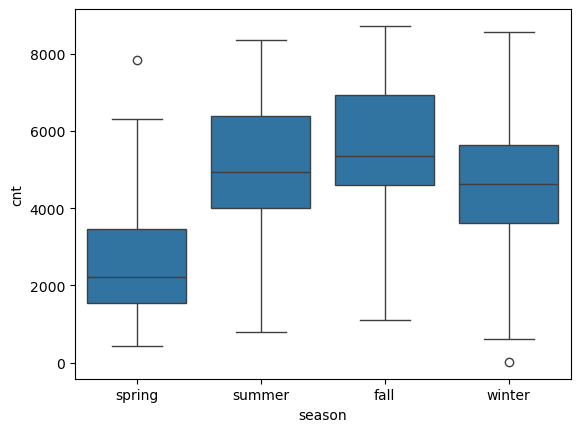

In [41]:
# Create a boxplot to visualize the distribution of 'cnt' (bike counts) for each season in the 'bike_new' DataFrame.
#Use 'season' as the categorical variable on the x-axis and 'cnt' on the y-axis.
sns.boxplot(x = 'season', y = 'cnt', data = bike_df) 
plt.show

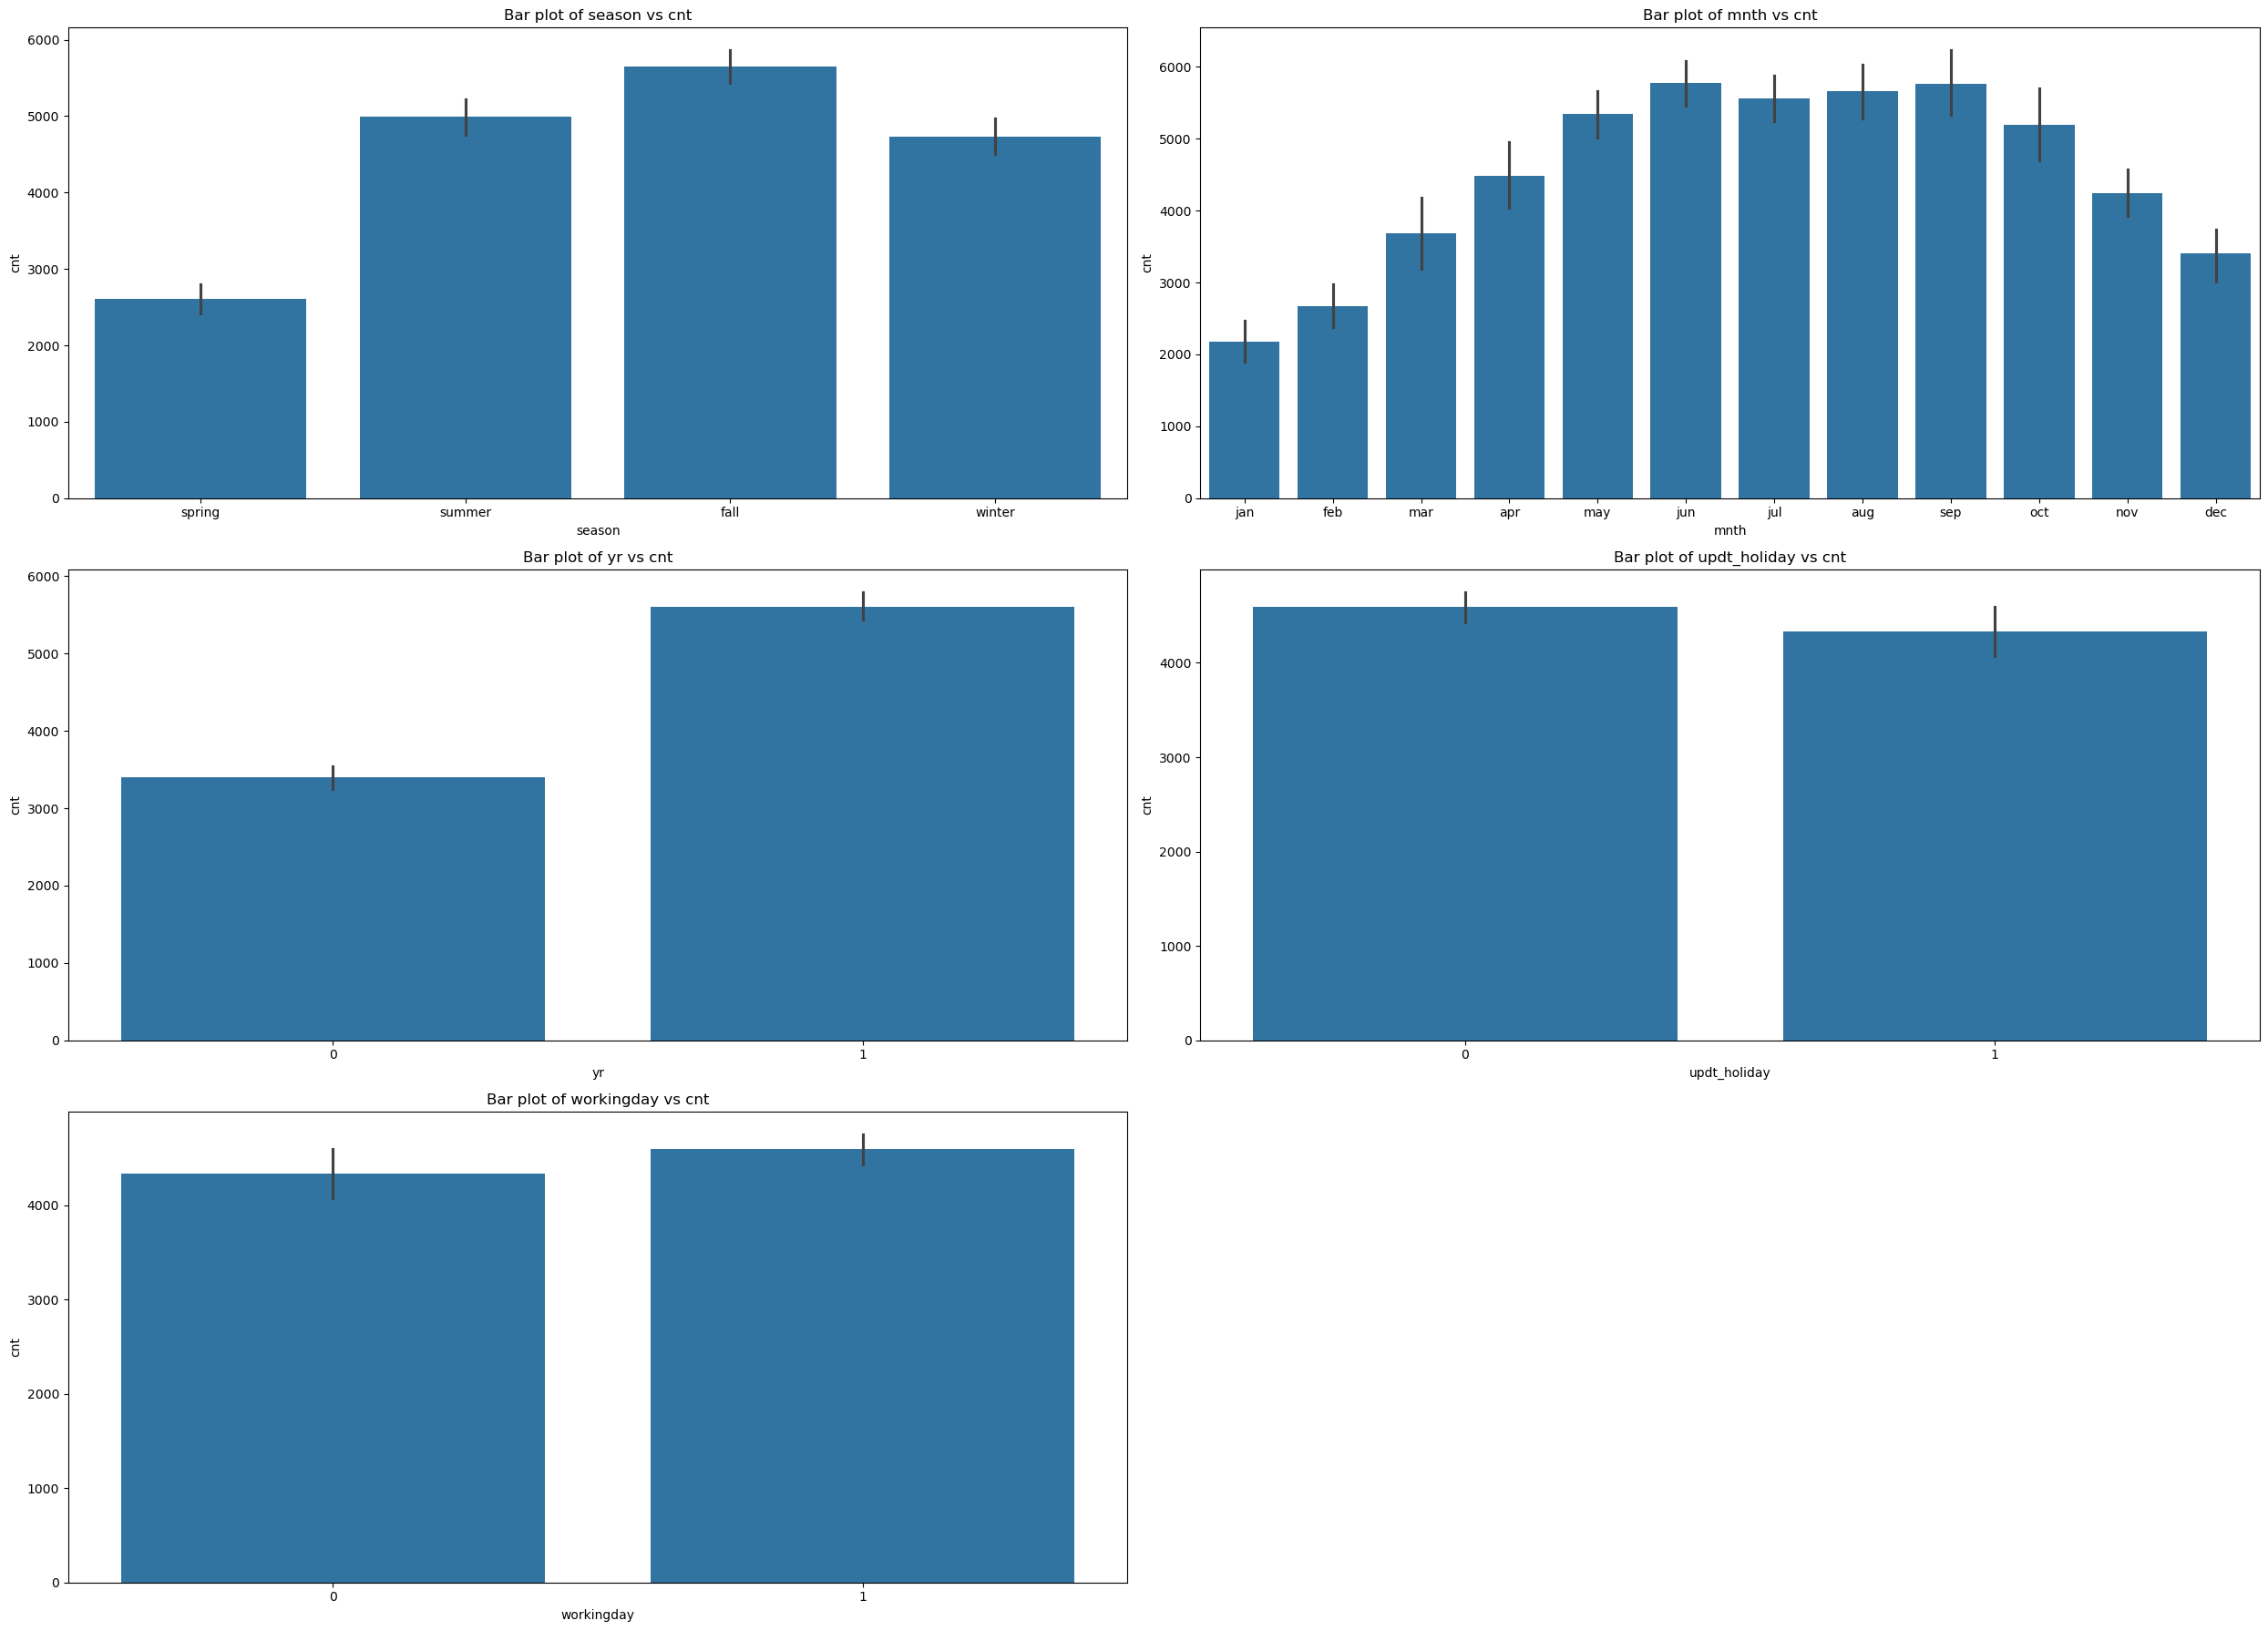

In [42]:
# Bar plot to show the relationship between the specified 'column' and 'cnt' (bike counts) in the 'bike_df' DataFrame.
# List of columns to plot
columns = ['season', 'mnth', 'yr', 'updt_holiday', 'workingday']

# Set up the subplot grid
plt.figure(figsize=(25, 18))  # Adjust figure size as needed

# Loop through each column and create a bar plot
for i, column in enumerate(columns, 1):  # Start indexing from 1 for subplot
    plt.subplot(3, 2, i)  # Create a 3x2 grid for subplots
    sns.barplot(x=column, y='cnt', data=bike_df)
    plt.title(f'Bar plot of {column} vs cnt')  # Add a title for each plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

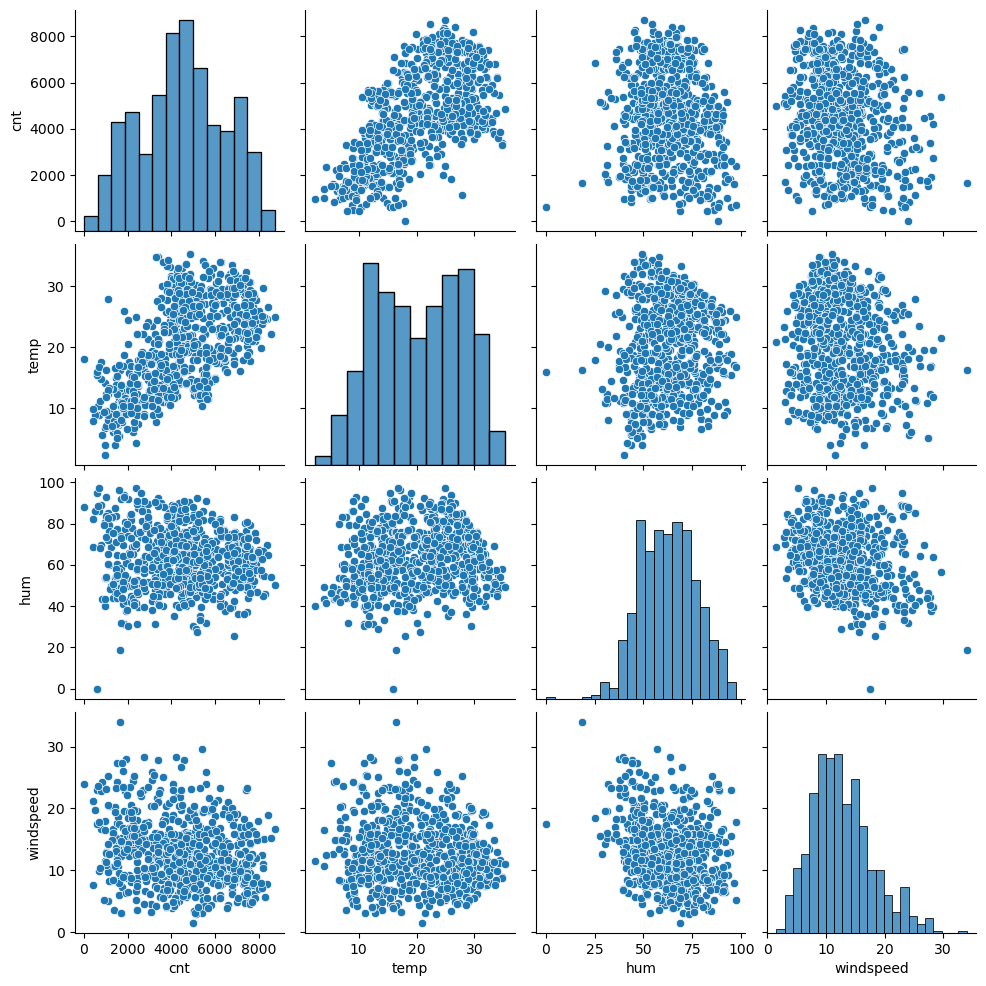

In [43]:
# Create pairwise scatter plots for the selected numeric variables ('temp', 'atemp', 'hum', 'windspeed', 'cnt') in the 'bike_new' DataFrame.
# This visualizes potential relationships or patterns between these variables.
sns.pairplot(data=bike_df,vars=['cnt','temp', 'hum', 'windspeed'])
# Display the resulting pairplot.
plt.show()

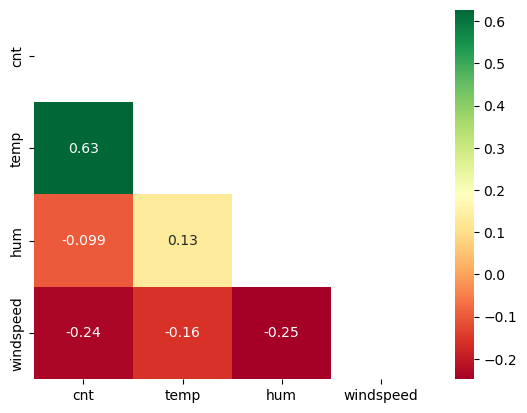

In [44]:
# Define the correlation matrix
correlation_matrix = bike_df[['cnt','temp', 'hum', 'windspeed']].corr()

# Create a mask for the upper triangle
matrix = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Now use the mask in the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn", mask=matrix)
plt.show()

**Observations from correlations with 'cnt':**
- 'temp' has a positive correlation of 0.63 with 'cnt', indicating that higher temperatures are associated with increased bike usage.
- 'hum' has a weak negative correlation of -0.099 with 'cnt', suggesting that humidity has little to no significant impact on bike usage.
- 'windspeed' has a moderate negative correlation of -0.24 with 'cnt', indicating that higher wind speeds may reduce bike usage to some extent.
- These correlations provide insights into how weather conditions influence bike rental counts, with temperature being the most impactful variable among the three.


# Step 3: Data Preparation

- Variables like 'weathersit' and 'season' have numeric values (1, 2, 3, 4) with associated labels, 
which might incorrectly imply an order. These features are converted to categorical string values 
to accurately reflect their nature before model building.

In [48]:
# Convert the 'season' & 'weathersit' column in the 'bike_df' DataFrame to the 'category' data type 
# to explicitly treat it as a categorical variable.
bike_df['season']=bike_df['season'].astype('category')
bike_df['weathersit']=bike_df['weathersit'].astype('category')

In [49]:
# Create dummy variables only for 'season' and 'weathersit'
# Drop the first category of each feature to avoid the dummy variable trap in regression models.
# This converts categorical data into a numerical format suitable for linear regression.
bike_df = pd.get_dummies(bike_df, columns=['season', 'weathersit'], drop_first=True)

# Convert dummy variables to 1 and 0 instead of True and False
# as 1 and 0 instead of True and False for compatibility with machine learning models.
dummy_columns = [col for col in bike_df.columns if 'season_' in col or 'weathersit_' in col]
bike_df[dummy_columns] = bike_df[dummy_columns].astype(int)


In [50]:
bike_df.head()

,cnt,yr,mnth,workingday,temp,hum,windspeed,updt_holiday,season_spring,season_summer,season_winter,weathersit_Light_Snow_Rain,weathersit_Mist
0,985,0,jan,0,14.110847,80.5833,10.749882,1,1,0,0,0,1
1,801,0,jan,0,14.902598,69.6087,16.652113,1,1,0,0,0,1
2,1349,0,jan,1,8.050924,43.7273,16.636703,0,1,0,0,0,0
3,1562,0,jan,1,8.200000,59.0435,10.739832,0,1,0,0,0,0
4,1600,0,jan,1,9.305237,43.6957,12.522300,0,1,0,0,0,0


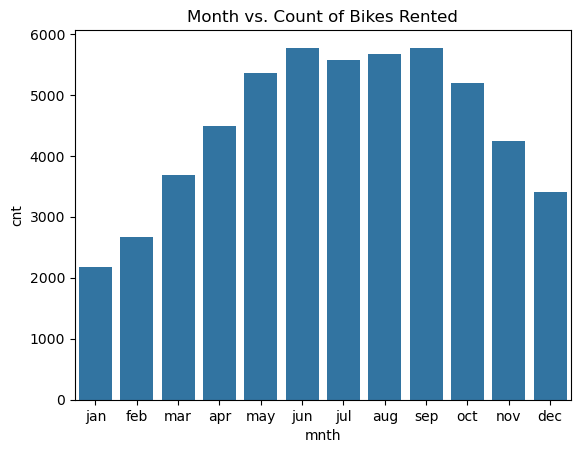

In [51]:
# 
sns.barplot(x='mnth', y='cnt', data=bike_df, ci=None)
plt.title("Month vs. Count of Bikes Rented")
plt.show()

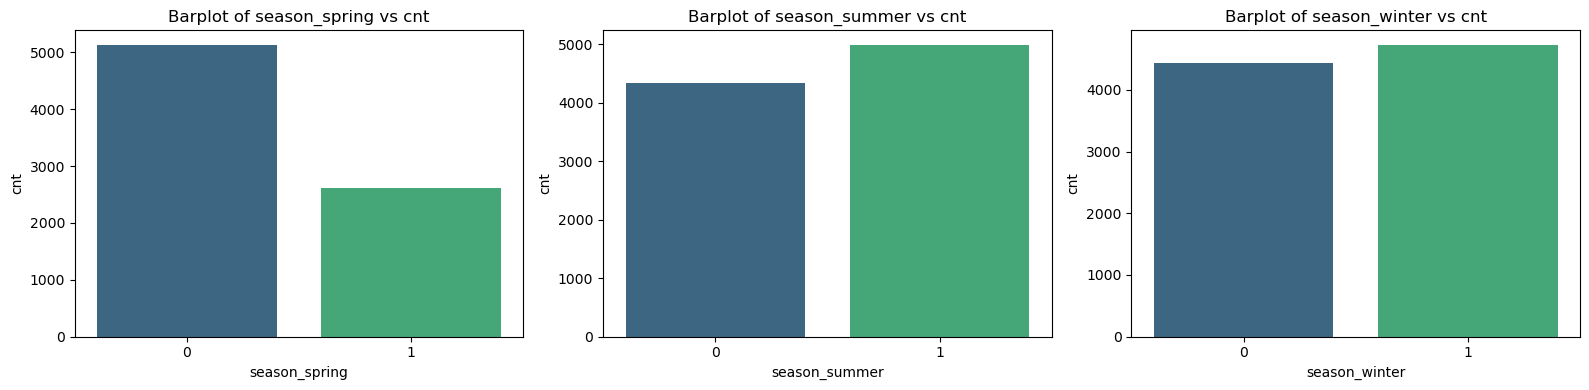

In [52]:
# List of season dummy columns
season_dummies = ['season_spring', 'season_summer', 'season_winter']

# Set up the figure for multiple barplots
plt.figure(figsize=(16, 4))

# Loop through each season dummy and plot
for i, season in enumerate(season_dummies):
    plt.subplot(1, len(season_dummies), i + 1)
    sns.barplot(x=season, y='cnt', data=bike_df, ci=None, palette="viridis")
    plt.title(f"Barplot of {season} vs cnt")
    plt.xlabel(season)
    plt.ylabel('cnt')

# Adjust layout
plt.tight_layout()
plt.show()

# List of season dummy columns and 'cnt'
season_dummies = ['season_spring', 'season_summer', 'season_winter', 'cnt']

# Calculate the correlation matrix
season_corr = bike_df[season_dummies].corr()

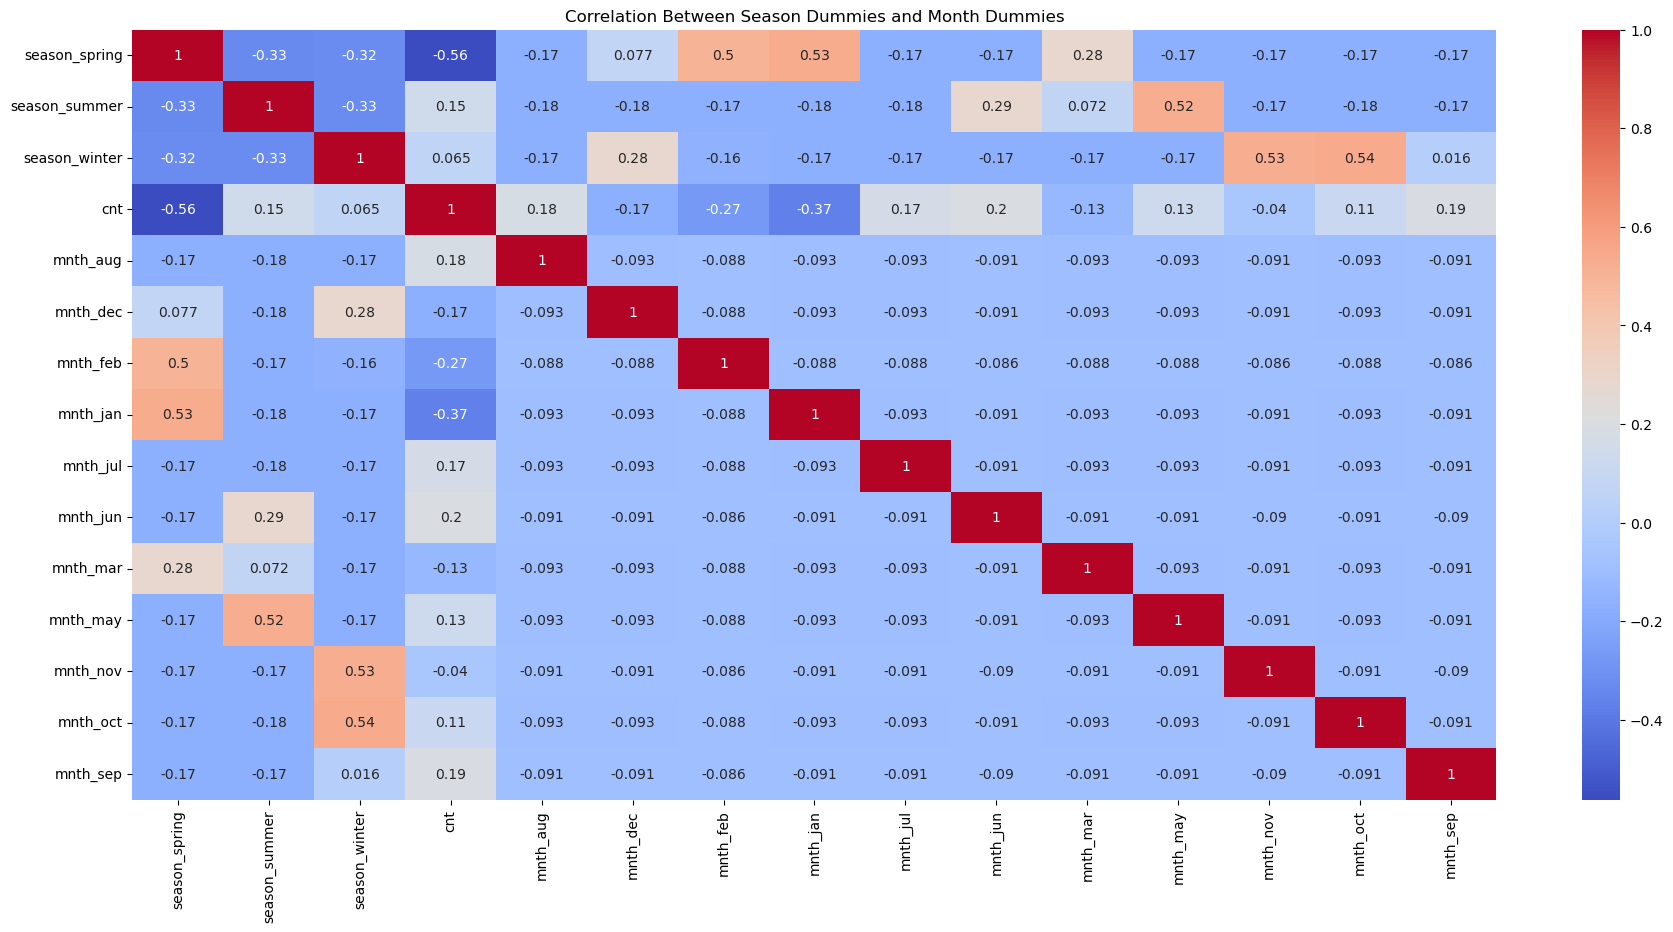

In [53]:
# Checking the correlation between season dummies and mnth and cnt
season_columns = ['season_spring', 'season_summer', 'season_winter','cnt']
mnth_dummies = pd.get_dummies(bike_df['mnth'], prefix='mnth', drop_first=True)

# Concatenate season, cnt and mnth dummies for analysis
combined_df = pd.concat([bike_df[season_columns], mnth_dummies], axis=1)
correlation_matrix = combined_df.corr()

# Display correlation heatmap
plt.figure(figsize=(22, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between Season Dummies and Month Dummies")
plt.show()

In [54]:
# Function to calculate Cramér's V
season_mnth_table = pd.crosstab(bike_df['season_summer'], bike_df['mnth']) # Crosstab of seasons and months
contingency_matrix = season_mnth_table.values # Convert the table to a NumPy array for calculations
chi2 = chi2_contingency(contingency_matrix)[0] # Calculate chi-squared statistic

# Total number of observations
n = contingency_matrix.sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_matrix.shape) - 1))) # Compute Cramér's V
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.8944170434800994


**Observation**
- The correlation analysis reveals that the mnth dummy variables have weak or negligible correlation with the target variable cnt, whereas the season dummy variables show a stronger and more meaningful relationship. Additionally, mnth dummies and season dummies are interrelated, as demonstrated by their strong Cramér's V value. 
- Since the seasonal representation is more intuitive and aligns better with weather-related patterns influencing bike rentals, retaining the season dummies while removing the mnth dummies simplifies the dataset without losing significant information.

In [56]:
# Identify and remove the 'mnth' dummy columns
mnth_dummies = [col for col in bike_df.columns if col.startswith('mnth_')]
bike_df.drop(columns=mnth_dummies, inplace=True)

# Drop the original 'mnth' column and its dummies
bike_df.drop(columns=mnth_dummies + ['mnth'], inplace=True)

# Confirm removal
print("Remaining columns:", bike_df.columns)

Remaining columns: Index(['cnt', 'yr', 'workingday', 'temp', 'hum', 'windspeed', 'updt_holiday',
       'season_spring', 'season_summer', 'season_winter',
       'weathersit_Light_Snow_Rain', 'weathersit_Mist'],
      dtype='object')


- **Preprocessing summary**
1. Removed redundant columns (instant, casual, registered, atemp, dteday, mnth, and its dummies).
2. Combined holiday and weekday into updt_holiday, ensuring compatibility with workingday.
3. Encoded and mapped categorical variables (season, weathersit) with meaningful labels and created necessary dummy variables.
4. Validated correlations to retain only informative features.
- The dataset is clean, consistent, and ready for Splitting Data for Model Building.

# Step 4: Splitting Data into Training and Testing Sets

### Train Test Split

In [60]:
# Splitting the dataset
df_train, df_test = train_test_split(bike_df, train_size=0.7, random_state=100)

# Print the shapes of the resulting splits
print(df_train.shape)
print(df_test.shape)

(510, 12)
(220, 12)


### Scaling the variables
 
- Why we need to do scaling.
    * Even Contribution of Features
    * Faster convergence for Gradient Descent Methods

**How to Achieve Scaling**
1. Standardization: Centers data around 0 with a standard deviation of 1. Useful for data with varying scales and algorithms sensitive to magnitude.
2. MinMax Scaling: Scales data to a fixed range, typically 0 to 1. Best for bounded data or when feature magnitude is important.

In [63]:
# we are using the MinMax Scaling
# Rescaling the data
scaler = MinMaxScaler()
# create a list of numeric vars
num_vars  = ['temp','hum','windspeed','cnt']
# For Training dataset we use scaler.fit_transform()
# For Test dataset we use scaler.transform()
# Fit_transform on Training data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,cnt,yr,workingday,temp,hum,windspeed,updt_holiday,season_spring,season_summer,season_winter,weathersit_Light_Snow_Rain,weathersit_Mist
576,0.827658,1,1,0.815169,0.725633,0.264686,0,0,0,0,0,0
426,0.465255,1,0,0.442393,0.640189,0.255342,1,1,0,0,0,1
728,0.204096,1,0,0.245101,0.498067,0.663106,1,1,0,0,0,0
482,0.482973,1,0,0.395666,0.504508,0.188475,1,0,1,0,0,1
111,0.191095,0,1,0.345824,0.751824,0.380981,0,0,1,0,0,1


In [64]:
# Checking if MinMax scaling was successfully applied
# The minimum values should be close to 0, and the maximum values close to 1.
df_train[num_vars].describe()

,temp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.650480,0.320883,0.513499
std,0.225858,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.538643,0.199179,0.356420
50%,0.542596,0.653714,0.296763,0.518638
75%,0.735215,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000


This confirms that the scaling process has been executed correctly.

In [66]:
# Separating the target variable ('cnt') from the training dataset
# 'y_train' will contain the target variable, and 'X_train' will contain the features
y_train = df_train.pop("cnt")
X_train = df_train

# Step 5: Feature Selection & Building Linear Model using statsmodels

### Objective:
- Develop a Multiple Linear Regression (MLR) model using the selected features.
- Evaluate the model's performance using statistical metrics (R-squared, Adjusted R-squared, etc.).
- Address multicollinearity by calculating VIF values and iteratively refining the model.

### Approach:
- Begin with all selected features and build the initial model.
- Calculate VIF values to identify multicollinearity among predictors.
- Refine the model by iteratively removing features with high VIF values while balancing the model's performance.
- Finalize the model once all VIF values are acceptable, ensuring an optimal and interpretable model.

### Feature Selection
- we will do this by -
    - fistly using the Recursive Feature Elimination (RFE) --> automated technique
    - after using Backward Elimination --> Manual technique

#### Recursive Feature Elimination (RFE)

In [71]:
# Step 1: Initialize a linear regression model to evaluate feature importance
lm = LinearRegression()

# Step 2: Fit the linear regression model on the training data
lm.fit(X_train, y_train)

# Step 3: Initialize RFE to select the top 13 features based on importance
# The 'n_features_to_select' parameter specifies the number of features to select
rfe = RFE(estimator=lm, n_features_to_select=13)

# Step 4: Fit RFE on the training data to rank features by their importance
rfe = rfe.fit(X_train, y_train)

# Step 5: Display the features, their selection status (True for selected), and their rank
# The output shows which features are selected in the top 12 list
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('updt_holiday', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('weathersit_Light_Snow_Rain', True, 1),
 ('weathersit_Mist', True, 1)]

- Features marked as True in the second column are selected in the top 12 most important features.
- These selected features will now be considered for the next steps in the model-building process.

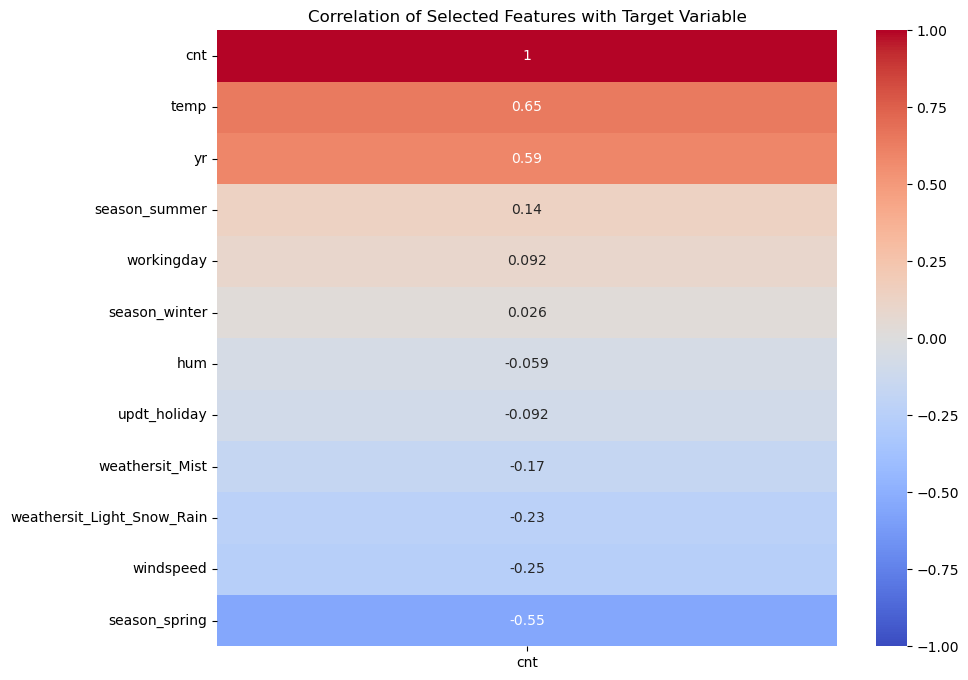

In [73]:
# Combine X_train with y_train temporarily for correlation analysis
selected_features = [
    'yr', 'workingday', 'temp', 'hum', 'windspeed', 'updt_holiday',
    'season_spring', 'season_summer', 'season_winter',
    'weathersit_Light_Snow_Rain', 'weathersit_Mist'
]

corr_data = X_train[selected_features].copy()
corr_data['cnt'] = y_train

# Calculate the correlation matrix
correlation_matrix_1 = corr_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_1[['cnt']].sort_values(by='cnt', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Selected Features with Target Variable')
plt.show()

- **Observation: Correlation Heatmap**
    - This heatmap provides a visual representation of how the selected features correlate with the target variable cnt.
    - Features with high positive or negative correlations (closer to 1 or -1) have a stronger linear relationship with the target, indicating their potential importance in predicting cnt.

#### Backward Elimination

In [76]:
# Function to Create and Fit an OLS Regression Model
def create_ols_model(X, y, drop_columns=None):
    """
    Create and fit an OLS regression model.

    Parameters:
        X (pd.DataFrame): Feature set (independent variables).
        y (pd.Series): Target variable (dependent variable).
        drop_columns (list, optional): List of columns to drop from X. Default is None.
    
    Returns:
        sm.OLS: Fitted OLS regression model.
        sm.OLSResults.summary: Summary of the fitted model.
    """
    if drop_columns:
        X = X.drop(columns=drop_columns, errors='ignore')  # Drop specified columns if needed

    X_with_constant = sm.add_constant(X)  # Add intercept
    ols_model = sm.OLS(y, X_with_constant).fit()  # Create and fit the model
    return ols_model, ols_model.summary()

# This function allows for building an Ordinary Least Squares (OLS) regression model.

In [77]:
# Define the function to calculate the vif
def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the dataset.

    Parameters:
        X (pd.DataFrame): Feature set (independent variables).
    
    Returns:
        pd.DataFrame: A DataFrame containing features and their respective VIF values.
    """
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["VIF"] = round(vif["VIF"], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    return vif

# Using the `calculate_vif` function:
# After building the initial model, we use this function to calculate and interpret VIF values for all predictors.
# - VIF > 5 indicates potential multicollinearity.
# Features with high VIF values indicate multicollinearity and should be considered for removal or transformation.

In [78]:
# Building the initial MLR model with all features
print("MLR Model : with all features")
# - Uses the `create_ols_model` function to fit the model on X_train and y_train.
model_bike_mlr, summary_bike_mlr = create_ols_model(X_train, y_train)
print(summary_bike_mlr)

MLR Model : with all features
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     236.0
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          5.55e-182
Time:                        23:09:32   Log-Likelihood:                 484.03
No. Observations:                 510   AIC:                            -946.1
Df Residuals:                     499   BIC:                            -899.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [79]:
# Calculating VIF for all features in the initial model
# - Uses the `calculate_vif` function to compute Variance Inflation Factor for each feature in X_train.
vif_1 = calculate_vif(X_train)
print("VIF for Iteration-1:")
vif_1

VIF for Iteration-1:


,Feature,VIF
1,workingday,49.34
5,updt_holiday,24.18
6,season_spring,4.54
2,temp,3.50
8,season_winter,3.10
7,season_summer,2.06
3,hum,1.87
10,weathersit_Mist,1.56
9,weathersit_Light_Snow_Rain,1.24
4,windspeed,1.20


**Observation**:
- The initial model shows a strong R-squared (0.825), indicating that 82.5% of the variance in the target variable is explained by the predictors.
- However, the VIF values highlight multicollinearity concerns:
   - `workingday` and `updt_holiday` have extremely high VIF values (i.e. 49.34 and 24.18, respectively), suggesting severe multicollinearity.
- following step: Iteratively remove features with high VIF and refit the model to address multicollinearity.

In [81]:
# The 'workingday' variable is dropped due to its extremely high VIF value (49.34), indicating severe multicollinearity.
X_train_new = X_train.drop(columns=['workingday'], errors='ignore')

In [82]:
# Rebuilding the MLR model after dropping the 'workingday' feature:
# After removing the 'workingday' variable, the model is refitted using the updated feature set (X_train_new).
print("MLR Model : after droping - 'workingday'")
model_bike_mlr, summary_bike_mlr = create_ols_model(X_train_new, y_train)
print(summary_bike_mlr)

MLR Model : after droping - 'workingday'
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     236.0
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          5.55e-182
Time:                        23:09:32   Log-Likelihood:                 484.03
No. Observations:                 510   AIC:                            -946.1
Df Residuals:                     499   BIC:                            -899.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [83]:
# Calculating VIF for Iteration-2:
# The `calculate_vif` function is used again on the updated feature set (X_train_new) after dropping the 'workingday' variable.
vif_2 = calculate_vif(X_train_new)
print("VIF for Iteration-2:")
vif_2

VIF for Iteration-2:


,Feature,VIF
2,hum,27.09
1,temp,14.81
3,windspeed,4.67
5,season_spring,3.72
7,season_winter,3.05
9,weathersit_Mist,2.28
6,season_summer,2.25
0,yr,2.08
4,updt_holiday,1.49
8,weathersit_Light_Snow_Rain,1.24


**Observations after dropping 'workingday':**
- The adjusted R-squared (0.822) remains stable, showing no loss in model performance.
- All variables remain statistically significant (P-value < 0.05).

**VIF Analysis:**
- 'hum' (27.09) and 'temp' (14.81) exhibit very high multicollinearity; they require further attention.
- Moderate multicollinearity is present in 'windspeed' (4.67) and 'season_spring' (3.72).
- Other variables have acceptable VIF values (< 5), indicating minimal multicollinearity.


In [85]:
# The 'hum' variable is dropped due to its very high VIF value (27.09), indicating high multicollinearity.
X_train_new = X_train_new.drop(columns=['hum'], errors='ignore')

In [86]:
# Creating a copy of the modified feature set
X_train_mlr = X_train_new.copy()
# Target variable
y = y_train # Use the same target variable for model fitting

# Fit the model after dropping 'hum' feature
print("MLR Model : after droping - 'hum'")
model_bike_mlr_2, summary_bike_mlr_2 = create_ols_model(X_train_mlr, y)
print(summary_bike_mlr_2)

MLR Model : after droping - 'hum'
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     254.8
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          1.87e-180
Time:                        23:09:32   Log-Likelihood:                 477.56
No. Observations:                 510   AIC:                            -935.1
Df Residuals:                     500   BIC:                            -892.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [87]:
# Calculating VIF for Iteration-3 after droping 'hum' feature:
vif_3 = calculate_vif(X_train_mlr)
print("VIF for Iteration-3:")
vif_3

VIF for Iteration-3:


,Feature,VIF
2,windspeed,4.62
1,temp,3.68
0,yr,2.07
4,season_spring,2.00
5,season_summer,1.80
6,season_winter,1.65
8,weathersit_Mist,1.53
3,updt_holiday,1.48
7,weathersit_Light_Snow_Rain,1.08


**Observations after dropping 'hum'**
- R-squared and Adjusted R-squared remain high (0.821 and 0.818, respectively), indicating that the model still explains a large portion of the variance (i.e. 82.1%) in the target variable.
- The F-statistic value is high (254.8), indicating that the overall regression model is statistically significant.
- The Prob (F-statistic) value is extremely low (1.87e-180), close to zero, which further confirms that the independent variables collectively have a strong explanatory power on the dependent variable.
- All remaining predictors are statistically significant (p < 0.05), showing that they contribute meaningfully to the model.
- VIF values of all the remaining features are now below 5, confirming the absence of multicollinearity among the predictors.
- The highest VIF is for 'windspeed' (4.62), which is within acceptable limits(VIF<5).
- Dropping 'hum' has reduced multicollinearity while maintaining the overall performance of the model.

### Final Model Selection


- The final model is set to 'model_bike_mlr_2' after iterative feature selection.

**This model demonstrates:**
 - High R-squared (0.821) and Adjusted R-squared (0.818), ensuring strong predictive power.
 - All predictors are statistically significant with acceptable p-values.
 - Multicollinearity issues have been resolved (all VIFs < 5).
 - Overall, the model balances simplicity and performance effectively.

In [91]:
# Assigning the refined model as the final model.
final_model = model_bike_mlr_2
print("Final MLR model'")
print(summary_bike_mlr_2)

Final MLR model'
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     254.8
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          1.87e-180
Time:                        23:09:32   Log-Likelihood:                 477.56
No. Observations:                 510   AIC:                            -935.1
Df Residuals:                     500   BIC:                            -892.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
con

**Final Model Interpretation:**

**Hypothesis Testing:**
 - Null Hypothesis (H0): B1 = B2 = ... = Bn = 0 (All coefficients are equal to zero; no relationship between predictors and the target variable).
 - Alternate Hypothesis (H1): At least one Bi ≠ 0 (At least one predictor has a significant relationship with the target variable).

 Based on the summary of the final model:
 - All predictors have non-zero coefficients, as indicated by their statistically significant p-values (all p-values < 0.05).
 - This evidence allows us to **REJECT the NULL HYPOTHESIS (H0)**.

Therefore, we conclude that the predictors collectively have a significant effect on the target variable in the final model.


# Step 6: Residual Analysis of the train data and validation

Residual analysis is a critical step in validating the assumptions of a linear regression model. 
- Here are the assumptions on which actions we'll take:
1. Normality of Error Terms
2. Homoscedasticity
3. Independence of Residuals
4. Verification of Linearity
5. Multicollinearity Verification

### 1. Normality of Error Terms: 
    - for this assumptions we will Plot a histogram of residuals to ensure they are approximately normally distributed.

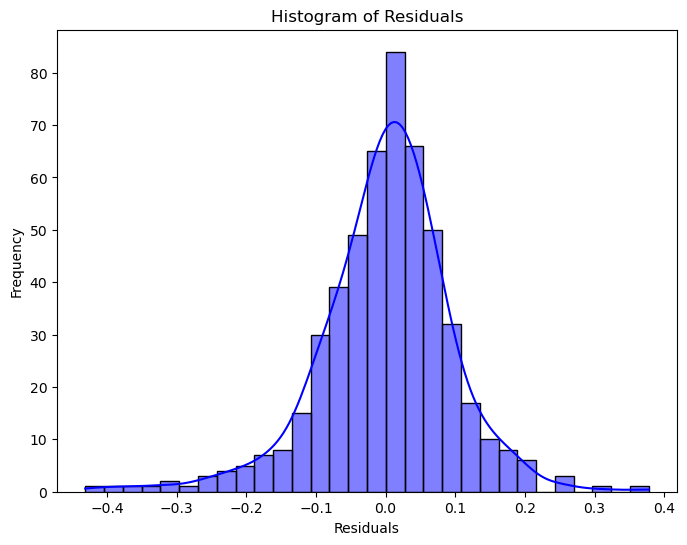

In [96]:
# Calculate residuals
residuals = y_train - final_model.fittedvalues 

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

**observation:**
- The error terms follow a normal distribution, as indicated by the peak centered around zero.
- This supports the assumption of normality for residuals.

### 2. Homoscedasticity
    - for this assumptions we will Plot the residuals against the predicted values to verify that the variance of residuals is constant (homoscedasticity).

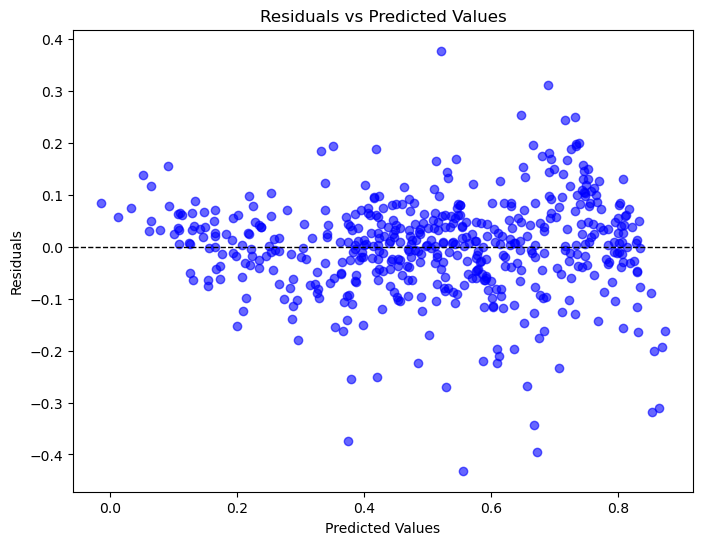

In [99]:
# Residual plot to check homoscedasticity
plt.figure(figsize=(8, 6))
plt.scatter(final_model.fittedvalues, residuals, alpha=0.6, color="blue")
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

**observation:**
- The residuals are scattered randomly around the zero line without any visible patterns, indicating homoscedasticity.
- This supports the constant variance of residuals.

### 3. Independence of Residuals
    - For this assumptions we will check the Durbin-Watson statistic from the model summary to test for autocorrelation in residuals.

In [102]:
# Calculate the Durbin-Watson statistic
durbin_watson_stat = durbin_watson(final_model.resid)
print("Durbin-Watson Statistic:", durbin_watson_stat)

Durbin-Watson Statistic: 2.003045098759271


**observation:**
- The Durbin-Watson statistic is 2.003, which is close to 2, suggesting no significant autocorrelation in the residuals.

### 4. Verification of Linearity
    - For this assumptions we will use Component and Component Plus Residual (CCPR) plots to validate the linear relationship between predictors and the target variable.

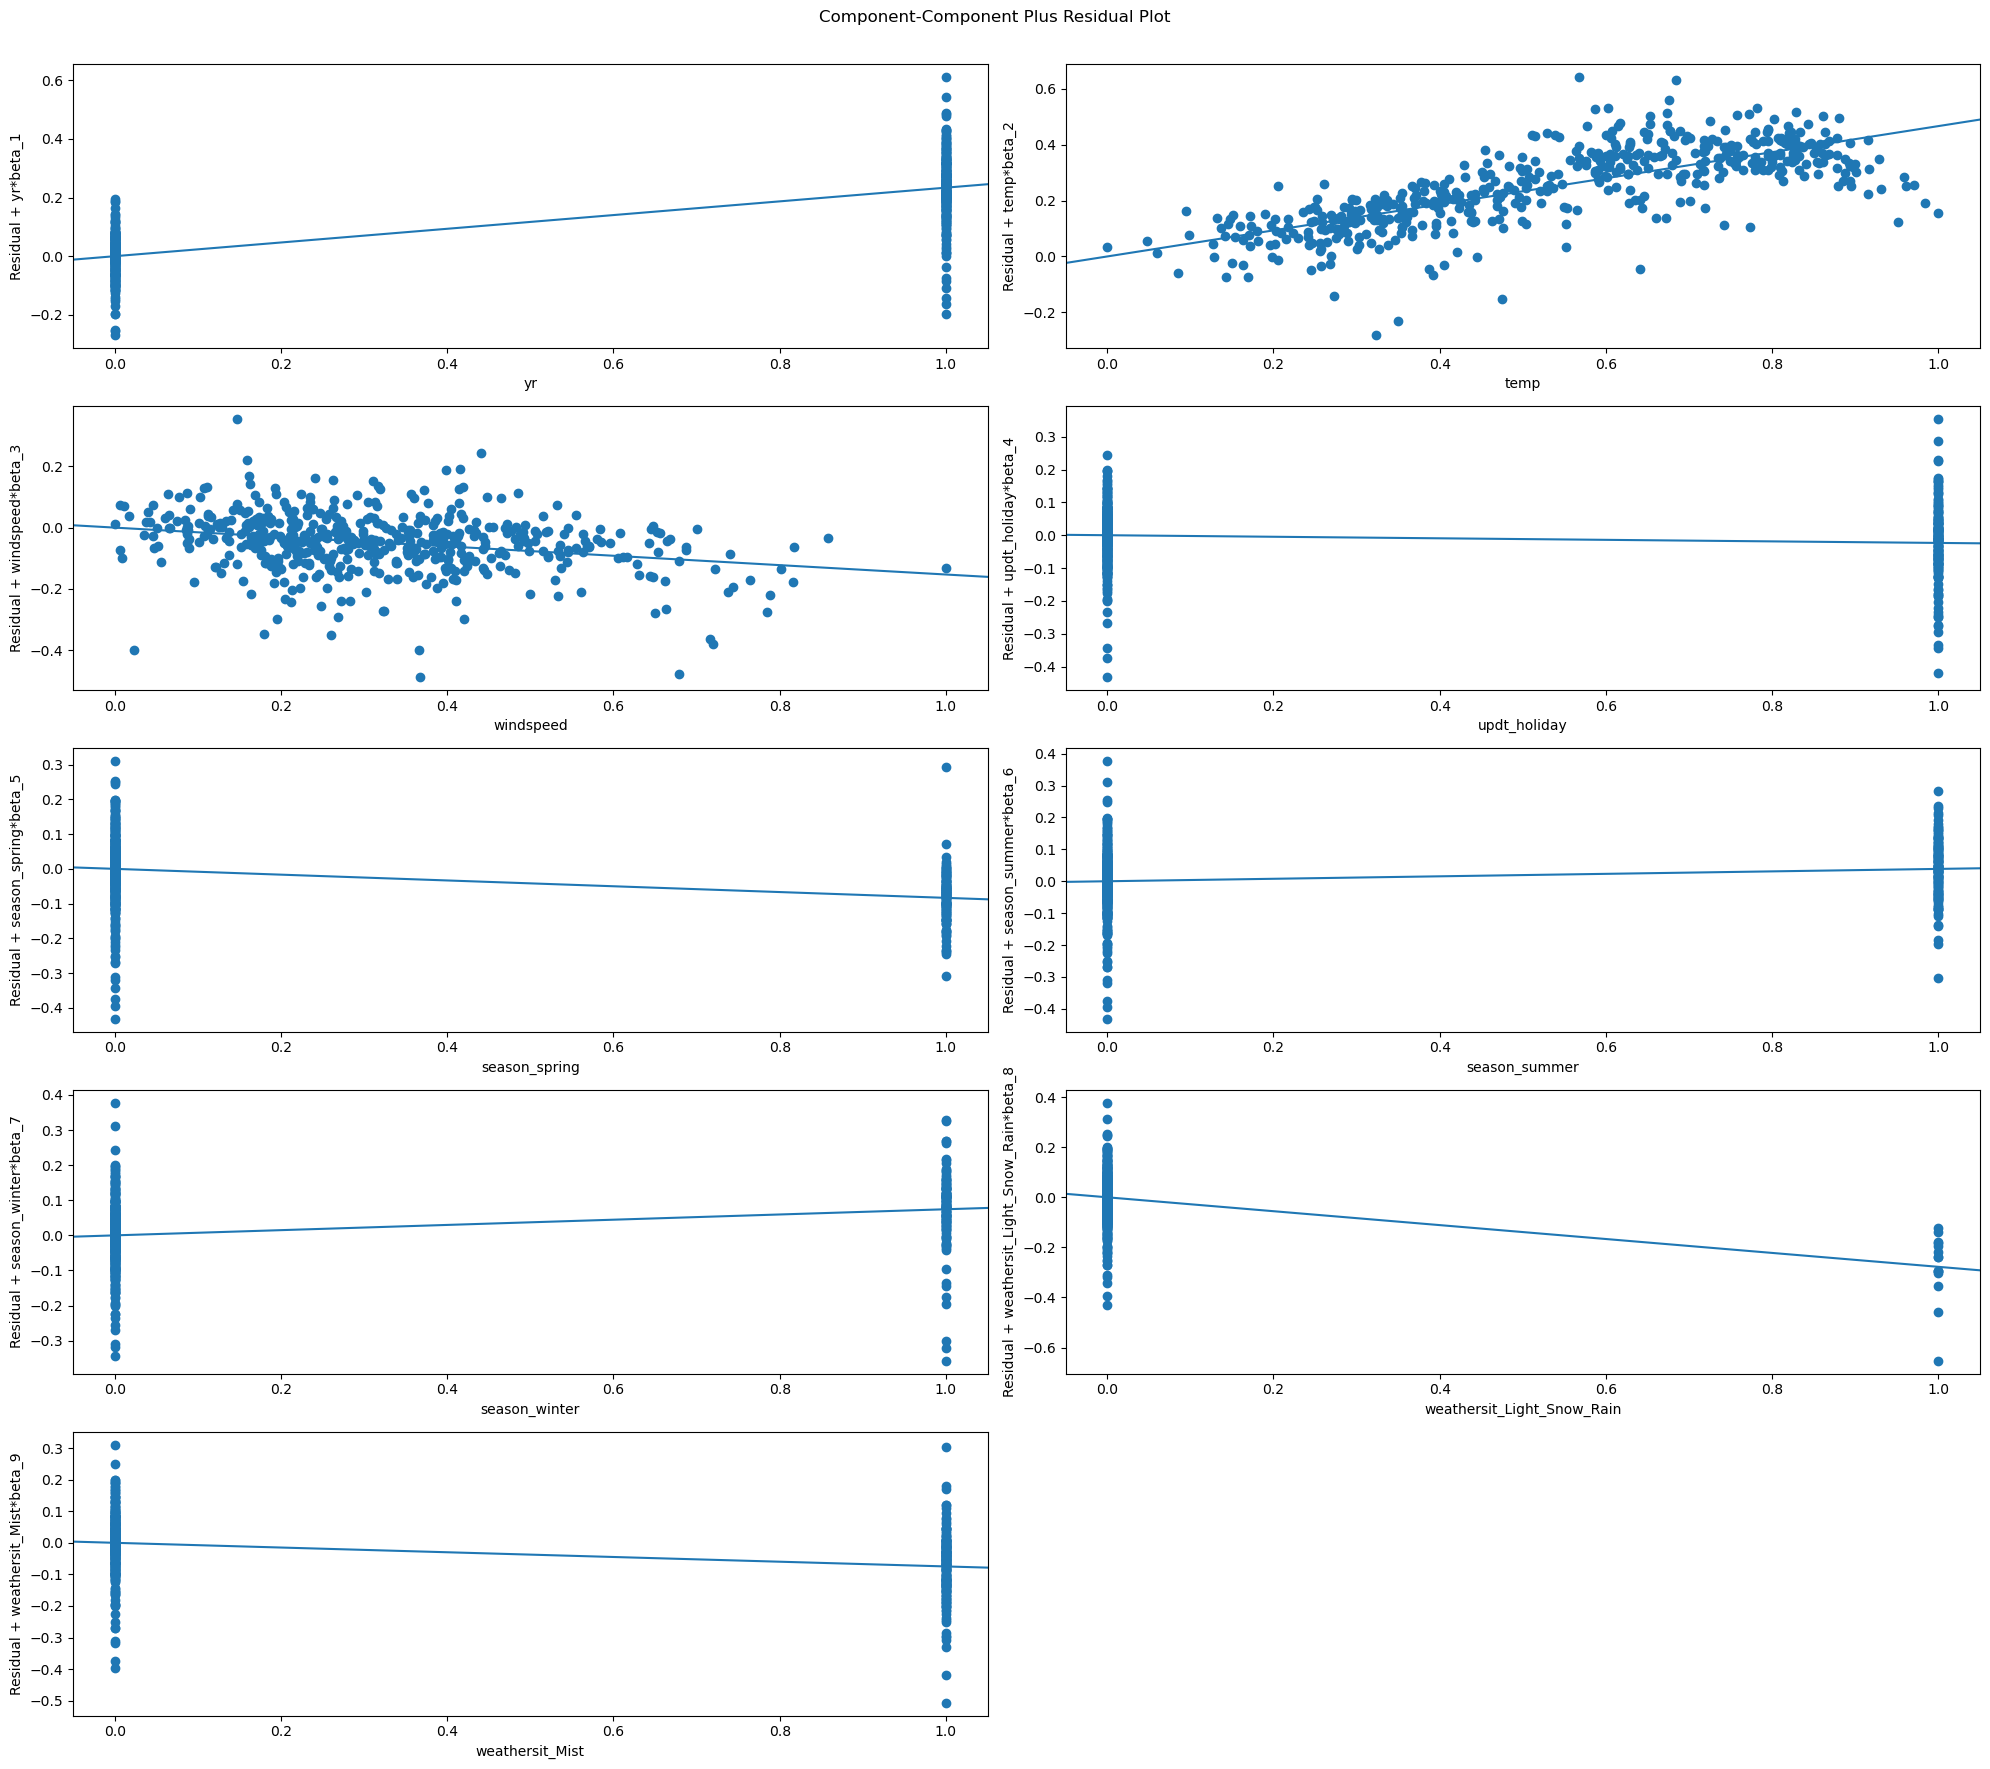

In [105]:
# Component and Component Plus Residual (CCPR) plots
fig = plt.figure(figsize=(20, 18))
sm.graphics.plot_ccpr_grid(final_model, fig=fig)
plt.show()

**observation:**
- The CCPR plots show some patterns in the residuals for predictors like `temp`, `windspeed`, `season_*`, `weathersit_*`, `yr`, and `updt_holiday`, indicating minor non-linearity.
- However, these deviations are not severe and the model retains reasonable linearity.

### 5.Multicollinearity Verification
    - For this assumption we wil check VIF values of predictors to confirm no significant multicollinearity exists.

In [108]:
# Verify multicollinearity using VIF
final_vif = calculate_vif(X_train_mlr)
print("Final VIF Values:")
print(final_vif)

Final VIF Values:
                      Feature   VIF
2                   windspeed  4.62
1                        temp  3.68
0                          yr  2.07
4               season_spring  2.00
5               season_summer  1.80
6               season_winter  1.65
8             weathersit_Mist  1.53
3                updt_holiday  1.48
7  weathersit_Light_Snow_Rain  1.08


**observation:**
- Final VIF values for all predictors are below 5, indicating no significant multicollinearity issues among the independent variables.

# Step 7: Predictions on Test Data Using the chosen Final Model

- Here are the steps we'll take:
1. Sacling the test data
2. Generate Predictions

### 1. Sacling the test data 
- Scaling the test data ensures it is on the same scale as the training data, 
- which is critical for consistent and accurate predictions using the final model.

In [113]:
# Define the list of numeric variables to be rescaled
num_vars  = ['temp', 'hum', 'windspeed', 'cnt']

# Apply the scaler (fitted on training data) to transform the numeric variables in the test data
# This ensures the test data is scaled consistently with the training data
df_test[num_vars] = scaler.transform(df_test[num_vars])

# Describe the num_vars for min close to 0 and max close to 1 for test data to confirm the scaling
df_test[num_vars].describe()

,temp,hum,windspeed,cnt
count,220.000000,220.000000,220.000000,220.000000
mean,0.558718,0.638221,0.313293,0.522154
std,0.233187,0.148694,0.159584,0.219163
min,0.046591,0.261915,-0.042808,0.048205
25%,0.355429,0.529197,0.198843,0.378595
50%,0.558172,0.625590,0.300126,0.524678
75%,0.755981,0.743798,0.402718,0.677750
max,0.984424,1.002146,0.807474,0.963300


### 1. Generate Predictions:
    - We will use the final model to predict values for the test dataset (X_test).

In [115]:
# Predictions on Test Data
# defining y_test and X-test
y_test = df_test.pop('cnt')
X_test = df_test

In [116]:
# Adding constant for prediction
X_test_sm = sm.add_constant(X_test) 
# verifing the addition of constant
X_test_sm.head()

,const,yr,workingday,temp,hum,windspeed,updt_holiday,season_spring,season_summer,season_winter,weathersit_Light_Snow_Rain,weathersit_Mist
184,1.0,0,0,0.831783,0.657364,0.084219,1,0,0,0,0,1
535,1.0,1,1,0.901354,0.610133,0.153728,0,0,1,0,0,0
299,1.0,0,1,0.511964,0.837699,0.334206,0,0,0,1,0,1
221,1.0,0,1,0.881625,0.437098,0.339570,0,0,0,0,0,0
152,1.0,0,1,0.817246,0.314298,0.537414,0,0,1,0,0,0


In [117]:
# Droping the 'workingday' and 'hum' in test data as we droped this in train data 
X_test_sm = X_test_sm.drop(['workingday', 'hum'], axis=1)

In [118]:
# Making predictions on Test Data 
y_test_pred = final_model.predict(X_test_sm)

# Step 8: Model Evaluation

- Here are the steps we'll take:
1. Evaluate Test Data Performance
2. Visualize Predictions
3. Comparison between Training dataset and Testing dataset
4. Cross-Validation

### 1. Evaluate Test Data Performance:

    - Calculate R-squared: Measures how well the model explains the variance in the test data.
    - Calculate Root Mean Squared Error (RMSE): Indicates the average prediction error in the test dataset.

In [122]:
# Calculate Test - R-squared and RMSE
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"Test R-squared: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

Test R-squared: 0.798
Test RMSE: 0.098


**Observations**
- Test R-squared of 0.798 indicates that approximately 80% of the variability in the test data is explained by the model.
- Test RMSE of 0.098 confirms the model's good predictive accuracy.

In [124]:
# Adjusted R^2 Value for TEST
# Number of observations and predictors
n_test = X_test_sm.shape[0]  # Number of rows in the test set
p_test = X_test_sm.shape[1] - 1  # Number of predictors (excluding constant term)

# Calculate Adjusted R-squared
adjusted_r2_test = 1 - ((1 - test_r2) * (n_test - 1) / (n_test - p_test - 1))

print(f"Test Adjusted R-squared:, {adjusted_r2_test:.3f}")

Test Adjusted R-squared:, 0.790


### 2. Visualize Predictions:

    - We are going to Plot the Actual vs. Predicted values for test data to evaluate the alignment.

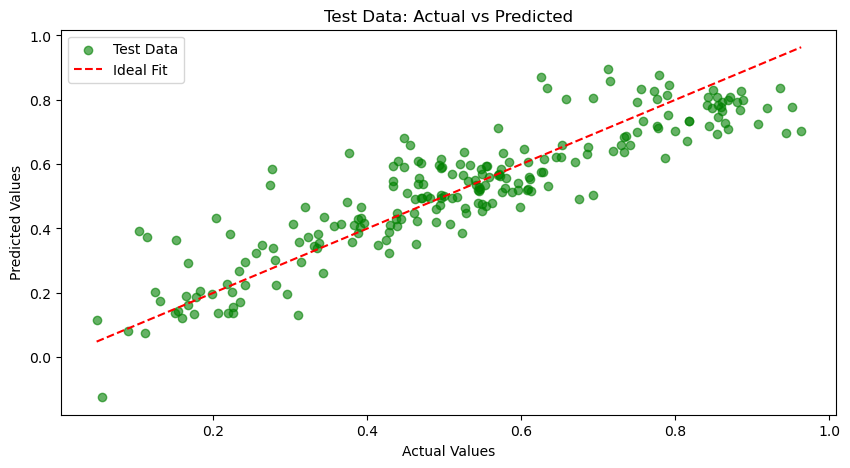

In [126]:
# Plot Actual vs Predicted for Test Data
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred, alpha=0.6, color="green", label="Test Data")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Test Data: Actual vs Predicted")
plt.legend()
plt.show()

**Observations**
- The scatterplot shows a strong positive correlation between actual and predicted values, supporting model accuracy.
- Points closely align with the ideal fit line, with minor deviations indicating areas for potential improvement.

{'Train MAE': 0.0686676131078838, 'Test MAE': 0.07540507759641574, 'Train RMSE': 0.09486284365101878, 'Test RMSE': 0.09817894635724873}


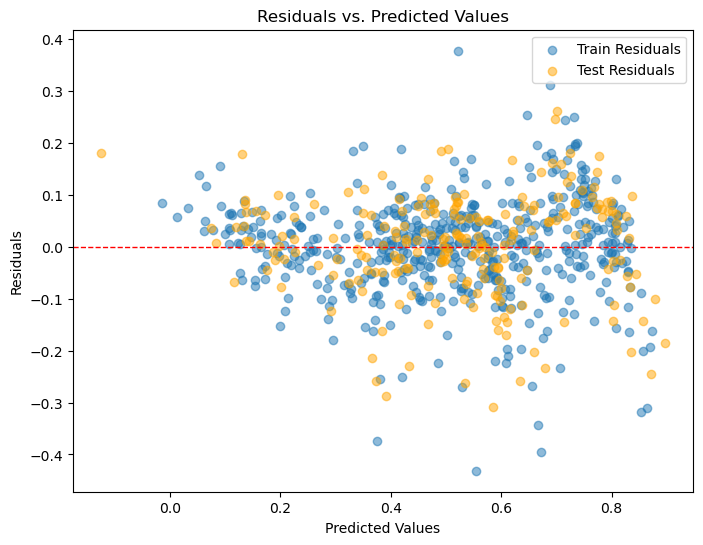

In [128]:
# Calculate Additional Metrics:
# Add intercept term to the train set
X_train_sm = sm.add_constant(X_train_mlr) 
# Predictions on train and test sets
y_train_pred = final_model.predict(X_train_sm)
y_test_pred = final_model.predict(X_test_sm)


# Calculate metrics
metrics = {
    "Train MAE": mean_absolute_error(y_train, y_train_pred),
    "Test MAE": mean_absolute_error(y_test, y_test_pred),
    "Train RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
    "Test RMSE": mean_squared_error(y_test, y_test_pred, squared=False),    
}

print(metrics)

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train - y_train_pred, label="Train Residuals", alpha=0.5)
plt.scatter(y_test_pred, y_test - y_test_pred, label="Test Residuals", alpha=0.5, color='orange')
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.legend()
plt.show()


**Observations**
- Random Distribution: Residuals for both train and test sets are randomly scattered around zero, indicating no systematic errors in the model predictions.
- No Pattern: Absence of visible trends in the residuals confirms the model's ability to capture the true relationship between predictors and the target variable.
- Similar Spread: Comparable spread of residuals across train and test datasets highlights consistent model performance.
- Residual Plot: The overall randomness and lack of structure in residuals validate key model assumptions and robustness.

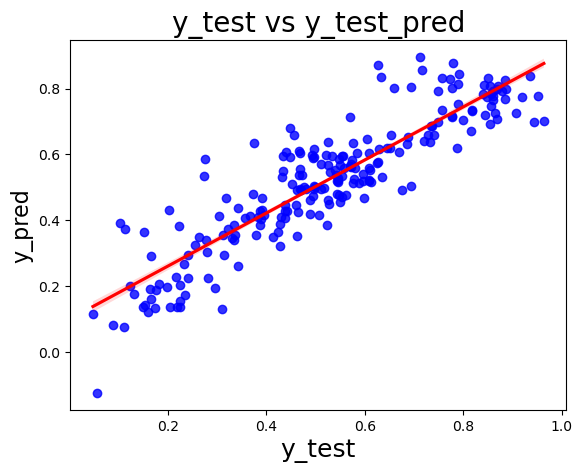

In [130]:
# Visualizing the fit on the test data by plotting a Reg plot between y_test, y_test_pred
plt.figure()
sns.regplot(x=y_test, y=y_test_pred, ci=68, fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_test vs y_test_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()

**Observations**
- The regression plot shows a strong positive correlation between actual test values (y_test) and predicted values (y_test_pred), indicating the model captures the relationship well.
- The scatter points around the fit line suggest minor prediction errors, with some outliers present, which could reflect unusual data points or model limitations.


## 3. Comparison between Training dataset and Testing dataset

In [133]:
# Metrics for comparison
print(f"Train dataset R²: {final_model.rsquared:.3f}")
print(f"Test dataset R²: {test_r2:.3f}")
print(f"Train dataset Adjusted R²: {final_model.rsquared_adj:.3f}")
print(f"Test dataset Adjusted R²: {adjusted_r2_test:.3f}")
print(f"Train dataset MAE: {mean_absolute_error(y_train, y_train_pred):.3f}")
print(f"Test dataset MAE: {mean_absolute_error(y_test, y_test_pred):.3f}")
print(f"Train dataset RMSE: {mean_squared_error(y_train, y_train_pred, squared=False):.3f}")
print(f"Test dataset RMSE: {mean_squared_error(y_test, y_test_pred, squared=False):.3f}")


Train dataset R²: 0.821
Test dataset R²: 0.798
Train dataset Adjusted R²: 0.818
Test dataset Adjusted R²: 0.790
Train dataset MAE: 0.069
Test dataset MAE: 0.075
Train dataset RMSE: 0.095
Test dataset RMSE: 0.098


- Train Dataset R² = 0.821: Explains 82.1% of variance, indicating a strong fit.
- Test Dataset R² = 0.798: Explains 79.8% of variance, showing good generalization.
- Train Adjusted R² = 0.8178: Confirms effective relationships in training data.
- Test Adjusted R² = 0.7898: Validates consistent performance on test data.
- **Observation: Metrics show minimal overfitting with consistent performance across datasets.**

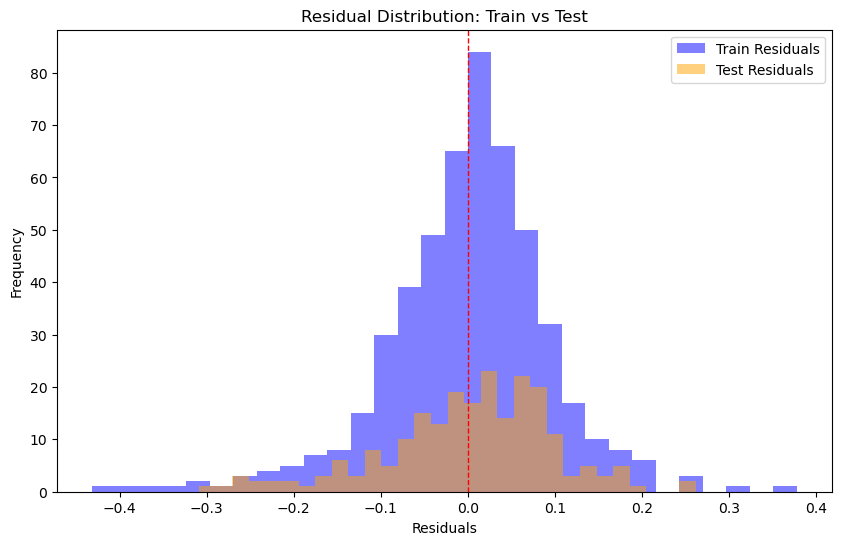

In [135]:
# Visualize Residual Distributions
# Plot the residuals for both datasets to compare how errors are distributed.
plt.figure(figsize=(10, 6))
plt.hist(y_train - y_train_pred, bins=30, alpha=0.5, label="Train Residuals", color="blue")
plt.hist(y_test - y_test_pred, bins=30, alpha=0.5, label="Test Residuals", color="orange")
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.title("Residual Distribution: Train vs Test")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()


**Observations**
- Normal Distribution: Both training and test residuals are approximately normally distributed around zero, indicating randomness in errors.
- Similar Shape: Training and test residuals have similar distributions, suggesting consistent model performance.
- Centered Around Zero: Residuals are centered around the ideal zero mean, showing unbiased predictions.


<function matplotlib.pyplot.show(close=None, block=None)>

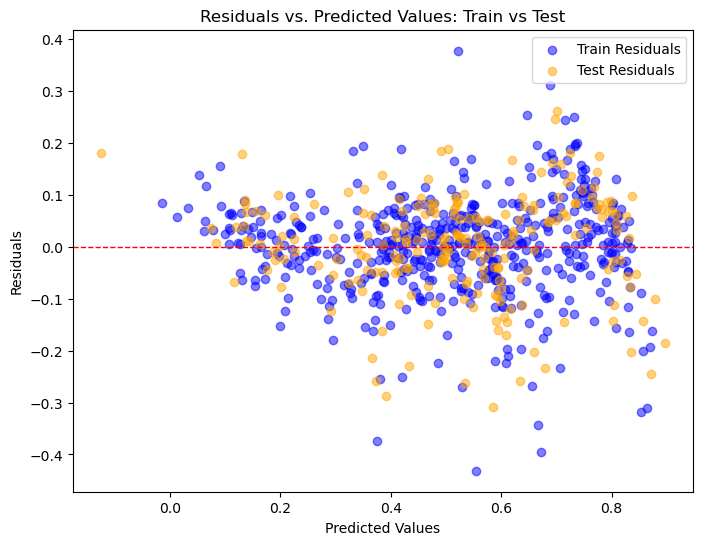

In [137]:
# Residual Scatter Comparison
# Create a combined scatter plot of residuals for training and test datasets.
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.5, label="Train Residuals", color="blue")
plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.5, label="Test Residuals", color="orange")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Residuals vs. Predicted Values: Train vs Test")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.show

**Observations**
- Random Distribution: Residuals for both training and test data are scattered around zero, indicating no systematic bias.
- No Pattern: No visible pattern in residuals, indicating the model captures the underlying relationship effectively.
- Similar Spread: Residuals show a comparable spread for training and test data, reflecting consistent model performance.

# Step 9: Interpretation & Conclusion

In [140]:
# Model Summary:
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     254.8
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          1.87e-180
Time:                        23:09:36   Log-Likelihood:                 477.56
No. Observations:                 510   AIC:                            -935.1
Df Residuals:                     500   BIC:                            -892.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

- Model Summary: This is the output of the linear regression model that provides details about the model coefficients, statistical significance, and other performance metrics.
 

- Brief explanation of key variables:
  - X_train_mlr: The feature matrix containing the predictor variables like temperature, wind speed, etc.
  - y_train: The target variable (bike rentals count) that we want to predict.
  - final_model: This is the trained linear regression model.
  - y_train_pred, y_test_pred: These are the predicted values of the target variable (bike rentals count) for the training and test sets.
  - train_mae, test_mae: The average absolute errors between predicted and actual values for both training and test sets.
  - train_rmse, test_rmse: The average squared errors between predicted and actual values for both training and test sets.
  - train_r2, test_r2: These represent the proportion of variance explained by the model, for both training and test sets.


- Model Interpretation:
  - R² gives us the percentage of variance explained by the model (higher is better).
  - MAE gives us the average error magnitude, where lower is better.
  - RMSE gives us the magnitude of the error, and we want it to be as low as possible.
  - The summary output from the model provides additional statistical insights like p-values, confidence intervals for coefficients, and other metrics.


### The equation of the best-fitted line
- derived by using the coefficients from your model's summary output. Each coefficient represents the contribution of the respective feature (predictor variable) to the model's prediction.

- **Bike Rentals (cnt)** = β0 + β1 × yr + β2 × temp+β3 × windspeed + β4 × updt_holiday + β5 × season_spring+β6 × season_summer + β7 × season_winter + β8 × weathersit_Light_Snow_Rain + β9 × weathersit_Mist

- **cnt** = 0.2272 + 0.2338 × `yr` + 0.4663 × `temp` − 0.1532 × `windspeed` − 0.0235 × `updt_holiday` − 0.0834 × `season_spring` + 0.0387 × `season_summer` + 0.0744 × `season_winter` − 0.2777 × `weathersit_Light_Snow_Rain` − 0.0748 × `weathersit_Mist`

- β₀ (Intercept):
    - 0.2272. This is the baseline number of bike rentals when all predictors are 0.
- β₁ to β₉:
    - The coefficients of each feature in the model (e.g., year, temperature, windspeed, holiday updates, season types, weather situation) tell you how the number of bike rentals changes as the corresponding feature value changes, assuming all other variables are held constant.

- Now we can identify the variable that has the highest impact on `cnt` by comparing the absolute values of the coefficients in the regression equation.
- The variable with the largest absolute coefficient contributes the most to changes in the target variable (`cnt`), assuming other variables are held constant.

- From the coefficients provided:
    - highest positive cf temp: 0.4663
    - largest negative cf weathersit_Light_Snow_Rain: −0.2777


### Conclusion:
- `temp` (Temperature) has the highest positive effect on bike rentals, with a coefficient of 0.4663. This means for every unit increase in temperature (scaled), bike rentals increase by 0.4663, assuming other variables remain constant.
- `weathersit_Light_Snow_Rain` has the largest negative impact (−0.2777). This indicates a significant drop in bike rentals during light snow or rain conditions.
- Thus, temperature is the most strongly affecting predictor for increasing `cnt`, while bad weather (`weathersit_Light_Snow_Rain`) has the most significant negative impact.

In [146]:
# R-squared score on the test set
r2_score(y_test, y_test_pred)

0.798405296344271